<a href="https://colab.research.google.com/github/andigu/crbm/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [785]:
import tensorflow as tf 
import tensorflow_probability as tfp
import numpy as np 
from sklearn.neural_network import BernoulliRBM
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import imageio
from datetime import datetime
import os
from qiskit.quantum_info import Statevector, Pauli
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_histogram, plot_state_paulivec
from qiskit.visualization.utils import _bloch_multivector_data
from tqdm.keras import TqdmCallback

# Real RBM

In [ ]:
class RBM(tf.keras.models.Model):
    def __init__(self, nv=2, nh=20, **kwargs):
        super(RBM, self).__init__(**kwargs)
        self.nv, self.nh = nv, nh
        self.W = tf.Variable(tf.random.normal((nv, nh)), trainable=True)
        self.bv = tf.Variable(tf.random.normal((nv, 1)), trainable=True) 
        self.bh = tf.Variable(tf.random.normal((nh, 1)), trainable=True)
        
    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random.uniform(p.shape)))
    
    def energy(self, v):
        b_term = tf.squeeze(tf.matmul(v, self.bv))
        linear_tranform = tf.matmul(v, self.W) + tf.squeeze(self.bh)
        h_term = tf.reduce_sum(tf.math.log(tf.exp(linear_tranform) + 1), axis=1) 
        return tf.reduce_mean(-h_term -b_term)
    
    def sample_h(self, v):
        ph_given_v = tf.sigmoid(tf.matmul(v, self.W) + tf.squeeze(self.bh))
        return self.bernoulli(ph_given_v)
    
    def sample_v(self, h):
        pv_given_h = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + tf.squeeze(self.bv))
        return self.bernoulli(pv_given_h)
    
    def gibbs_step(self, i, vk):
        hk = self.sample_h(vk)
        vk = self.sample_v(hk)
        return i+1, vk
    
    def gibbs_sample(self, n_samples, n_steps=3):
        init = tf.cast(tf.random.uniform(shape=(n_samples, self.nv), maxval=1) <= 0.5, tf.float32)
        _, x_samples = tf.while_loop(cond=lambda i, _: i <= n_steps, body = rbm.gibbs_step, 
                              loop_vars = [0, init], parallel_iterations=1,)
        return x_samples
    
    def call(self, x):
        x_samples = self.gibbs_sample(100*len(x))
        self.add_loss(self.energy(x) - self.energy(tf.stop_gradient(x_samples)))

In [ ]:
def to_freq(data):
    data = np.packbits(data.astype(np.int), axis=1, bitorder='little').flatten()
    vals, freq = np.unique(data, return_counts=True)
    return freq/freq.sum()

In [ ]:
from tqdm import trange
data_vals = []
weights = np.random.normal(size=4)
probs = np.abs(np.random.normal(size=4))
probs = probs/probs.sum()
for _ in trange(1000):
    tmp = np.random.choice(4, p=probs, size=5000)
    options = np.array([[0,0],[0,1],[1,0],[1,1]])
    X = options[tmp].astype(np.float32)
    data_vals.append(weights @ (to_freq(X)))

100%|██████████| 1000/1000 [00:00<00:00, 1522.73it/s]


In [ ]:
X.shape

(5000, 2)

In [ ]:
rbm = RBM(nh=20)
rbm_vals = []
rbm.compile(optimizer=tf.optimizers.SGD(0.1))
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)
]
rbm.fit(X, batch_size=10, verbose=2, epochs=200, callbacks=callbacks)
rbm.load_weights('model.h5')
to_freq(rbm.gibbs_sample(100000, n_steps=3).numpy()), to_freq(X)
for _ in trange(100):
    rbm_vals.append(weights @ (to_freq(rbm.gibbs_sample(100000).numpy())))

Epoch 1/200
500/500 - 1s - loss: 0.0129
Epoch 2/200
500/500 - 1s - loss: 0.0137
Epoch 3/200
500/500 - 1s - loss: 0.0232
Epoch 4/200
500/500 - 1s - loss: 0.0185
Epoch 5/200
500/500 - 1s - loss: 0.0193
Epoch 6/200
500/500 - 1s - loss: 0.0185
Epoch 7/200
500/500 - 1s - loss: 0.0088
Epoch 8/200
500/500 - 1s - loss: 0.0045
Epoch 9/200
500/500 - 1s - loss: 0.0046
Epoch 10/200
500/500 - 1s - loss: 0.0018
Epoch 11/200
500/500 - 1s - loss: 0.0022
Epoch 12/200
500/500 - 1s - loss: 0.0035
Epoch 13/200
500/500 - 1s - loss: 0.0018
Epoch 14/200
500/500 - 1s - loss: 0.0034
Epoch 15/200
500/500 - 1s - loss: 0.0014
Epoch 16/200
500/500 - 1s - loss: 0.0034
Epoch 17/200
500/500 - 1s - loss: 0.0027
Epoch 18/200
500/500 - 1s - loss: 5.7491e-04
Epoch 19/200
500/500 - 1s - loss: 0.0021
Epoch 20/200
500/500 - 1s - loss: 0.0014
Epoch 21/200
500/500 - 1s - loss: 0.0019
Epoch 22/200
500/500 - 1s - loss: 0.0027
Epoch 23/200
500/500 - 1s - loss: 0.0017
Epoch 24/200
500/500 - 1s - loss: 0.0014
Epoch 25/200
500/500 

100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


In [ ]:
np.round(to_freq(rbm.gibbs_sample(100000).numpy()),3), np.round(to_freq(X),3)

(array([0.326, 0.147, 0.162, 0.365]), array([0.325, 0.146, 0.164, 0.366]))

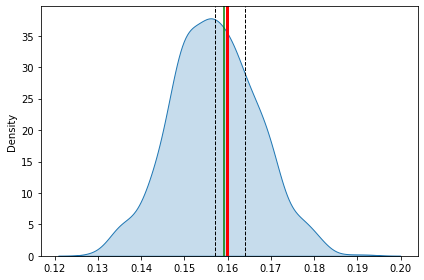

In [ ]:
sns.kdeplot(data_vals, fill=True)
plt.axvline(np.percentile(np.array(rbm_vals), 5), c='black', ls='--', lw=1)
plt.axvline(np.percentile(np.array(rbm_vals), 95), c='black', ls='--', lw=1)
plt.axvline(np.percentile(np.array(rbm_vals), 50), c='red', lw=3)
plt.axvline(weights@to_freq(X), c='green')
plt.tight_layout()

# Complex RBM

In [865]:
N = 2
psi_z = np.random.normal(size=2**N) + np.random.normal(size=2**N) * 1j
psi_z = psi_z/np.linalg.norm(psi_z)
psi_z.round(2)

array([ 0.57+0.23j,  0.29+0.02j, -0.27-0.03j, -0.18-0.65j])

In [866]:
COBS = np.array([
    [
     [-1/np.sqrt(2), 1/np.sqrt(2)], # complex conjugate of 1st x vector in z basis
     [ 1/np.sqrt(2), 1/np.sqrt(2)]
    ],
    [
     [1j/np.sqrt(2), 1/np.sqrt(2)], # complex conjugate of 1st y vector
     [-1j/np.sqrt(2), 1/np.sqrt(2)]
    ],
    [
     [1, 0],
     [0, 1]
    ]
])

def kron(matrices):
    ret = np.array([[1]])    
    for mat in reversed(matrices):
        ret = np.kron(mat, ret)
    return ret

def draw_from_psi(psi_z, N, basis):
    sigma = kron(np.take(COBS, basis, axis=0))
    psi_proj = (sigma @ psi_z[:,np.newaxis]).flatten()
    probs = (psi_proj * np.conj(psi_proj)).real
    res = np.random.multinomial(n=1, pvals=probs, size=N)
    return np.argwhere(res)[:,1]

X_samples = draw_from_psi(psi_z, N=7000, basis=[0]*N)
Z_samples = draw_from_psi(psi_z, N=7000, basis=[2]*N)

In [867]:
import itertools

class CRBM(tf.keras.models.Model):
    def __init__(self, nv=1, nh=5):
        super(CRBM, self).__init__()
        self.nv, self.nh = nv, nh
        self.bv = tf.Variable(initial_value=CRBM.random_normal((nv,1)), dtype=tf.dtypes.complex64)
        self.bh = tf.Variable(initial_value=CRBM.random_normal((nh,1)), dtype=tf.dtypes.complex64)
        self.W = tf.Variable(initial_value=CRBM.random_normal((nv, nh)), dtype=tf.dtypes.complex64)
        v_vecs = np.array([list("{0:b}".format(x).zfill(nv)) for x in np.arange(2**nv)]).astype(np.int)
        self.v_vecs = tf.cast(tf.convert_to_tensor(v_vecs), tf.dtypes.complex64)
        self.COBS = np.zeros(shape=[3]*nv + [2**nv,2**nv]).astype(np.complex64)
        for coord in itertools.product([0,1,2], repeat=nv):
            self.COBS[coord] = kron(np.take(COBS, coord, axis=0))

    
    @staticmethod
    def random_normal(shape):
        return np.random.normal(size=shape) + 1j*np.random.normal(size=shape)
    
    def psi(self, v):
        """
        Accepts only length N binary strings
        """
        if tf.rank(v) == 1:
            v = tf.expand_dims(v, axis=-1)
        elif tf.rank(v) == 2:
            v = tf.transpose(v)
        ret = tf.linalg.adjoint(self.bv) @ v + tf.reduce_sum(tf.math.log(tf.math.conj(tf.exp(self.bh + tf.linalg.adjoint(self.W) @ v)) + 1), axis=0)
        return tf.transpose(tf.exp(ret))

    def prob(self, spins, basis):
        basis = tf.cast(basis, tf.int64)
        indexing = tf.concat((basis, spins), axis=-1)
        sigma = tf.math.conj(tf.cast(tf.gather_nd(self.COBS, indexing), tf.dtypes.complex64)) # sigma = <v_i | measured state vector>
        psi_vec = self.psi(self.v_vecs)
        psi_proj = sigma @ psi_vec
        return tf.cast(psi_proj*tf.math.conj(psi_proj)/tf.linalg.norm(psi_vec)**2, tf.float32)

    def call(self, measurement):
        spins = measurement[0]
        basis = measurement[1]
        probs = self.prob(spins, basis=basis)
        loss = -tf.math.reduce_mean(tf.math.log(probs))
        self.add_loss(loss)

In [868]:
bs = 100
measurements = np.concatenate((X_samples, Z_samples), axis=0)
bases = np.concatenate((np.zeros((len(X_samples), N)), 2*np.ones((len(Z_samples), N))), axis=0)

In [871]:
!rm -rf imgs
!mkdir imgs

class Visualize(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        if epoch <= 20 or epoch % 5 == 0:
            bloch_data = _bloch_multivector_data(qiskit.quantum_info.Statevector(psi_z))
            psi = self.model.psi(self.model.v_vecs).numpy()
            psi = psi/np.linalg.norm(psi)
            bloch_data2 = _bloch_multivector_data(qiskit.quantum_info.Statevector(psi))
            num = len(bloch_data)
            width, height = plt.figaspect(1/num)
            fig = plt.figure(figsize=(width, height))
            for i in range(num):
                ax = fig.add_subplot(1, num, i + 1, projection='3d')
                plot_bloch_vector(bloch_data[i], "qubit " + str(i), ax=ax)
                plot_bloch_vector(bloch_data2[i], "qubit " + str(i), ax=ax)
            fig.suptitle(f"Epoch {epoch}", fontsize=16)
            fig.savefig(f"imgs/epoch-{str(epoch).zfill(3)}.png", bbox_inches='tight')
            plt.close(fig)
    
    def on_train_end(self, logs):
        images = []
        for filename in sorted(os.listdir("imgs/"), key=lambda x: int(x.split('.')[0][-3:])):
            images.append(imageio.imread(f"imgs/{filename}"))
        for _ in range(10):
            images.append(imageio.imread(f"imgs/{filename}"))
        date = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
        imageio.mimsave(f'{date}.gif', images)
        self.model.load_weights("model.h5")

bs = 200
crbm = CRBM(nv=N, nh=5)
crbm.compile(optimizer=tf.optimizers.Adam(0.1))
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30),
    tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='loss', verbose=False, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=False, min_lr=1e-5),
    tf.keras.callbacks.CSVLogger("training.csv"),
    # Visualize(),
    TqdmCallback(batch_size=bs)
]
hist = crbm.fit(x=(measurements, bases), verbose=False, epochs=200, callbacks=callbacks, batch_size=bs, shuffle=True)

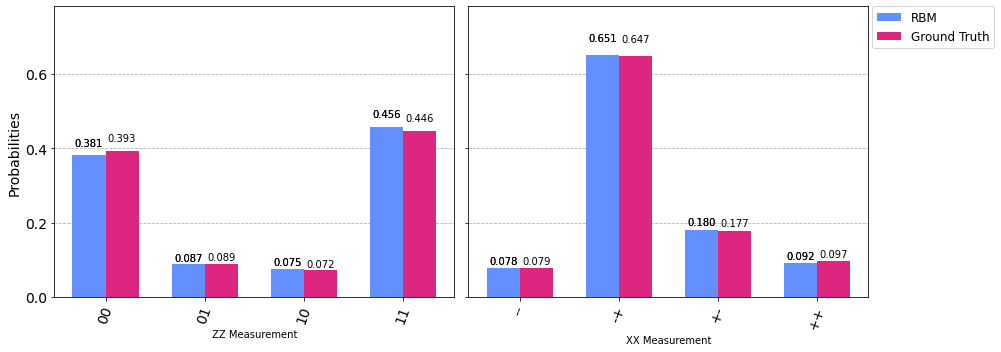

In [876]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)
psi = crbm.psi(crbm.v_vecs).numpy()
psi = psi/np.linalg.norm(psi)

plot_histogram([Statevector(crbm.COBS[2][2] @ np.expand_dims(psi_z, axis=-1)).probabilities_dict(),
                Statevector(crbm.COBS[2][2] @ psi).probabilities_dict()], ax=ax1)
ax1.set_xlabel("ZZ Measurement")

plot_histogram([Statevector(crbm.COBS[0][0] @ np.expand_dims(psi_z, axis=-1)).probabilities_dict(),
                Statevector(crbm.COBS[0][0] @ psi).probabilities_dict()], ax=ax2, legend=['RBM', 'Ground Truth'])
ax2.set_xticklabels(['--', '-+', '+-', '++'])
ax2.set_xlabel("XX Measurement")
ax2.set_ylabel(None)
ax1.grid(axis='y', linestyle='--')
fig.tight_layout()
fig.savefig("measurements.png")